# Author: Kartik B Bhargav

#  Anomaly Detection with VAEs
As we have seen, Variational Autoencoders (VAEs) provide a mathematically grounded framework for the unsupervised learning of latent representations. Besides interpreting VAEs as representation learning or generative modelling, we can also see them as performing (approximate) density approximation. VAEs are trained to optimise a lower bound to the (log) likelihood $\log p(X)$ of the data $X$, under the chosen model. So, for any point in data space, we can obtain an estimate of its likelihood under the trained model, by simply computing the loss function when passing this data point through the neural network (note that the loss function is the negative ELBO, so we need to multiply by -1 to obtain a likelihood estimation).

We can use this idea to perform unsupervised anomaly detection. Suppose we are given a dataset that describes some natural distribution (e.g. images of certain clothing items). For new test data, we then wish to detect whether it fits this distribution, or is significantly different (an anomaly). For example, given a dataset of shirts, we want to detect anomalies in a test data set that also contains some images of trousers. Typically, such a situation occurs when we have many examples of one class (e.g. shirts), but very few of others (the anomalies, e.g. trousers).

In this task, we will perform and evaluate such anomaly detection with VAEs. Given a training data set that consists of instances that we consider "normal", we wish to detect anomalies in a test data set that contains both "normal" (but unseen) examples, as well as other examples which we consider anomalous. The idea is to train a VAE on the training data, such that it learns to represent "normal" data well. We can then compute the ELBO values for the test data, where ideally "normal" examples should obtain higher likelihood values than anomalous examples.

In this assignment, we will use FashionMNIST to simulate the anomaly detection task. We will omit one class from the training data, and consider the remaining 9 classes to be "normal". The goal is then to identify the omitted class in the test data, by comparing the ELBO values obtained from a VAE trained on 9 classes.


## Imports
These should be all the imports you'll need, please don't use any other libraries as this will make it harder to assess your work.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, precision_recall_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1: Obtain anomaly detection dataset
**(a)** We will consider the "Trouser" class (with label 1) to be the anomalies, and consider the other 9 classes to be our "normal" data. We'll train on normal data only, but we want to test on both normal and anomalous data to evaluate our anomaly detection framework.
* Load the FashionMNIST dataset.
* Remove all instances from the anomaly class from the training set.
* Split the test set in two parts: the anomalous data (with label 1) and the normal data (all other labels).


In [2]:
#### INSERT CODE HERE ####
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train[y_train != 1]
x_train = (x_train / 255).reshape(x_train.shape + (1,)).astype('float32')
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

x_test = (x_test / 255).reshape(x_test.shape + (1,)).astype('float32')
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

x_test_normal_data= x_test[y_test != 1]
x_test_anomalous_data = x_test[y_test == 1]

# saving number of images in training data; height, width and depth of each image
n_train, height, width, depth = x_train.shape

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test_normal: ", x_test_normal_data.shape)
print("y_test: ", y_test.shape)
print("x_test_anomaly: ", x_test_anomalous_data.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train:  (54000, 32, 32, 1)
y_train:  (60000,)
x_test_normal:  (9000, 32, 32, 1)
y_test:  (10000,)
x_test_anomaly:  (1000, 32, 32, 1)


**(b)** To check if the split was done correctly, plot some random examples (at least 10 each) of:
* The new training set (without the anomaly class)
* The normal test set
* The anomaly test set

Training set without Anomaly class data


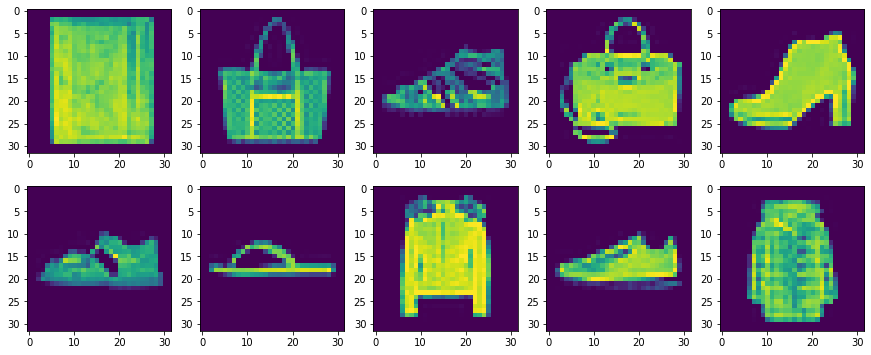

Test set : normal data


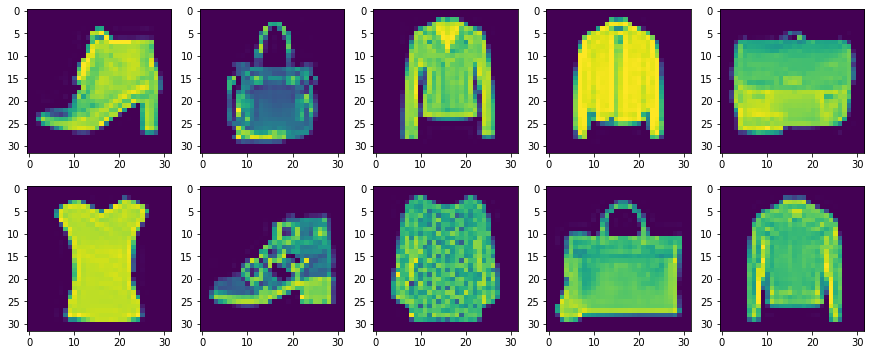

Test set: anomalous data


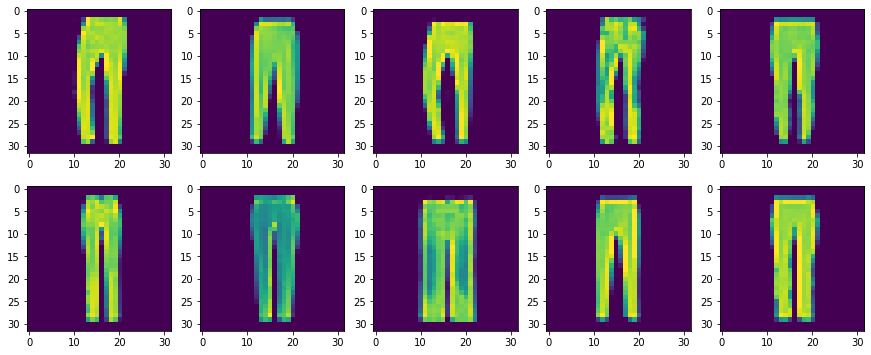

In [3]:
#### INSERT CODE HERE ####

print("Training set without Anomaly class data")
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for rows in axes:
    for subplot in rows:
        idx = np.random.randint(0, x_train.shape[0]-1)
        subplot.imshow(x_train[idx][:, :, 0])
plt.show()

print("Test set : normal data")
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for rows in axes:
    for subplot in rows:
        idx = np.random.randint(0, x_test_normal_data.shape[0] - 1)
        subplot.imshow(x_test_normal_data[idx][:, :, 0])
plt.show()

print("Test set: anomalous data")
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for rows in axes:
    for subplot in rows:
        idx = np.random.randint(0, x_test_anomalous_data.shape[0]-1)
        subplot.imshow(x_test_anomalous_data[idx][:, :, 0])

## Task 2: Design, implement, and train a VAE
**(a)** Design a VAE for the FashionMNIST dataset with a suitable architecture, that should perform well on this dataset.
* Implement the VAE (with corresponding loss functions) and compile it.
* Print a summary (with `.summary()`) of the encoder and decoder.


In [4]:
#### INSERT CODE HERE ####

latent_dimension = 8

# Gaussian Sampling Class
class GaussianSampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mu)), mean=0, stddev=1)
        return z_mu + epsilon * K.exp(z_log_sigma)

# Encoder 
input_layer = layers.Input(shape=(height, width, depth), name="encoder_input_layer")

# Convolution block - 1

# (32, 32, 1)  -> (32, 32, 64)
hidden_layer = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(input_layer)

# (32, 32, 64) -> (16, 16, 64)
hidden_layer = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(hidden_layer)  

# Convolution block - 2

# (16, 16, 64)  -> (16, 16, 128)
hidden_layer = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(hidden_layer)

# (16, 16, 128) -> (8, 8, 128)
hidden_layer = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(hidden_layer)

# Dense layers

# (8, 8, 128) -> (8 * 8 * 128,)
hidden_layer = layers.Flatten()(hidden_layer)

# (8 * 8 * 128,)  -> (256,)
hidden_layer = layers.Dense(256, activation="relu")(hidden_layer)

# (256,) -> (128,)
hidden_layer = layers.Dense(128, activation="relu")(hidden_layer)

# mu parameter of q(z|x)
z_mu = layers.Dense(latent_dimension, name='z_mu')(hidden_layer)

# log of sigma parameter of q(z|x)
z_log_sigma = layers.Dense(latent_dimension, name='z_log_sigma')(hidden_layer)  

encoder = Model(input_layer, [z_mu, z_log_sigma], name='encoder')
encoder.summary()

# instantiating Gaussian sampling class with z_mu and z_log_sigma layers
z_sample = GaussianSampling(name="z_sample")([z_mu, z_log_sigma])


# Decoder

decoder_input = layers.Input(shape=(latent_dimension,), name='decoder_input_layer')

# (latent_dimension,) -> (128,) (encoding dimension)
hidden_layer = layers.Dense(128, activation='relu')(decoder_input)

# (128,) -> (256,)
hidden_layer = layers.Dense(256, activation='relu')(hidden_layer)

# (256,) -> (8 * 8 * 128,)
hidden_layer = layers.Dense(8 * 8 * 128, activation='relu')(hidden_layer)

# (8 * 8 * 128,) -> (8, 8, 128)
hidden_layer = layers.Reshape((8, 8, 128))(hidden_layer)

# Reverse Convolution block - 2:

# (8, 8, 128 ) -> (16, 16, 128)
hidden_layer = layers.UpSampling2D(size=(2,2))(hidden_layer)

# (16, 16, 128) -> (16, 16, 64)
hidden_layer = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(hidden_layer)

# Reverse Convolution block - 1:

# (16, 16, 64) -> (32, 32, 64)
hidden_layer = layers.UpSampling2D(size=(2,2))(hidden_layer)

# (32, 32, 64) -> (32, 32, 1)
decoder_output = layers.Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid')(hidden_layer)

decoder = Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


# Loss functions

x_mean = decoder(z_sample)
vae = Model(input_layer, x_mean, name="VAE")

x_std = (1 / np.sqrt(2)).astype(np.float32)

x_in_flat = K.batch_flatten(input_layer)
x_mean_flat = K.batch_flatten(x_mean)

reconstruction_loss = K.sum(K.square(x_in_flat - x_mean_flat) / (2 * x_std**2) + K.log(x_std) + 0.5 * K.log(2 * np.pi), axis=-1)
kl_loss = 0.5 * K.sum(K.square(z_mu) + K.exp(2 * z_log_sigma) - 2 * z_log_sigma - 1, axis=-1)

vae_loss = reconstruction_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer="adam")


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_layer (InputLayer [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   640         encoder_input_layer[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       max_pooling2d[0][0]              
____________________________________________________________________________________________

**(b)** Train the VAE on the FashionMNIST training dataset without the anomaly class. Make sure that you train long enough such that the loss is no longer going down. Make sure that the training output is printed (use the default `verbose` setting in `.fit`).

In [5]:
#### INSERT CODE HERE ####

batch_size = 100
epochs = 60

early_stopping_callback = EarlyStopping(monitor="loss",
                                        patience=2,
                                        restore_best_weights=True,)

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_callback])

Epoch 1/60
540/540 [==============================] - 18s 33ms/step - loss: 622.4144
Epoch 2/60
540/540 [==============================] - 18s 33ms/step - loss: 612.7885
Epoch 3/60
540/540 [==============================] - 18s 33ms/step - loss: 611.8141
Epoch 4/60
540/540 [==============================] - 18s 33ms/step - loss: 611.3315
Epoch 5/60
540/540 [==============================] - 18s 33ms/step - loss: 611.0914
Epoch 6/60
540/540 [==============================] - 18s 33ms/step - loss: 610.8686
Epoch 7/60
540/540 [==============================] - 18s 33ms/step - loss: 610.7627
Epoch 8/60
540/540 [==============================] - 18s 33ms/step - loss: 610.6294
Epoch 9/60
540/540 [==============================] - 18s 33ms/step - loss: 610.4678
Epoch 10/60
540/540 [==============================] - 18s 33ms/step - loss: 610.4370
Epoch 11/60
540/540 [==============================] - 18s 33ms/step - loss: 610.3519
Epoch 12/60
540/540 [==============================] - 18s 33ms

## Task 3: Inspect VAE performance
Qualitatively inspect if the VAE is trained well. The latent space plots we saw in the practical only work for 2-dimensional latent spaces, but you may need to increase the dimensionality of the latent space for good performance. Therefore we'll make some plots that work for higher-dimensional latent spaces as well; reconstructions and random samples:

* __Reconstructions:__ Take a random sample of normal training images (at least 10), and use the VAE to obtain their reconstructions. Plot both originals and reconstructions, on top of each other.
* __Random samples:__ Randomly generate some images (at least 10) with the VAE; i.e. sample latent variables from the prior distribution, and decode them into data space. Plot the results.

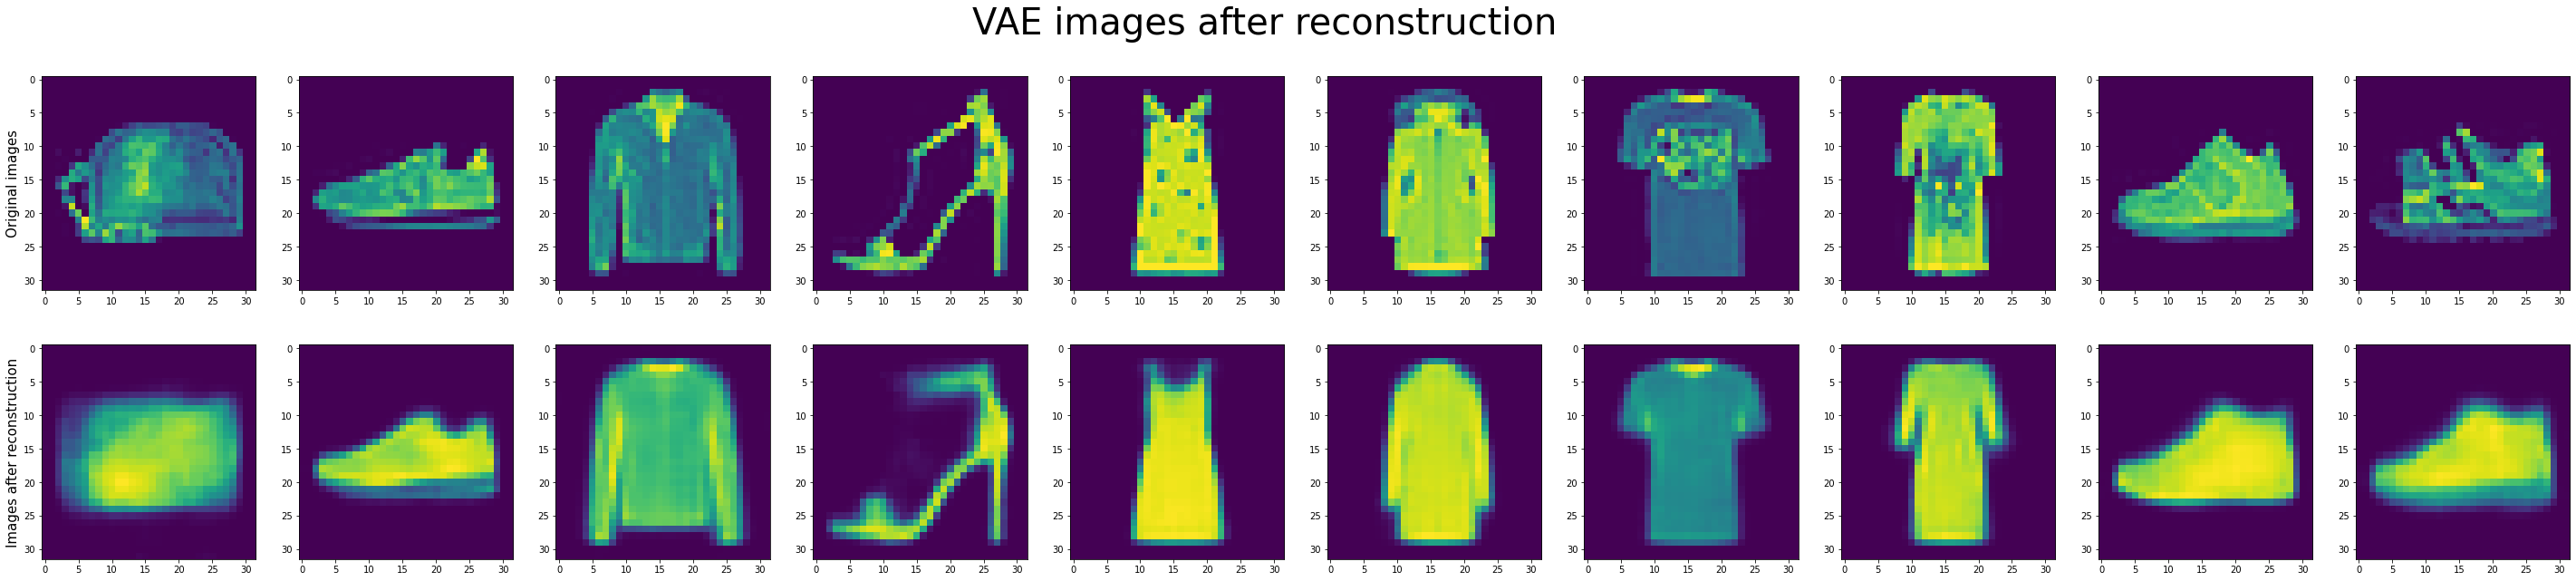

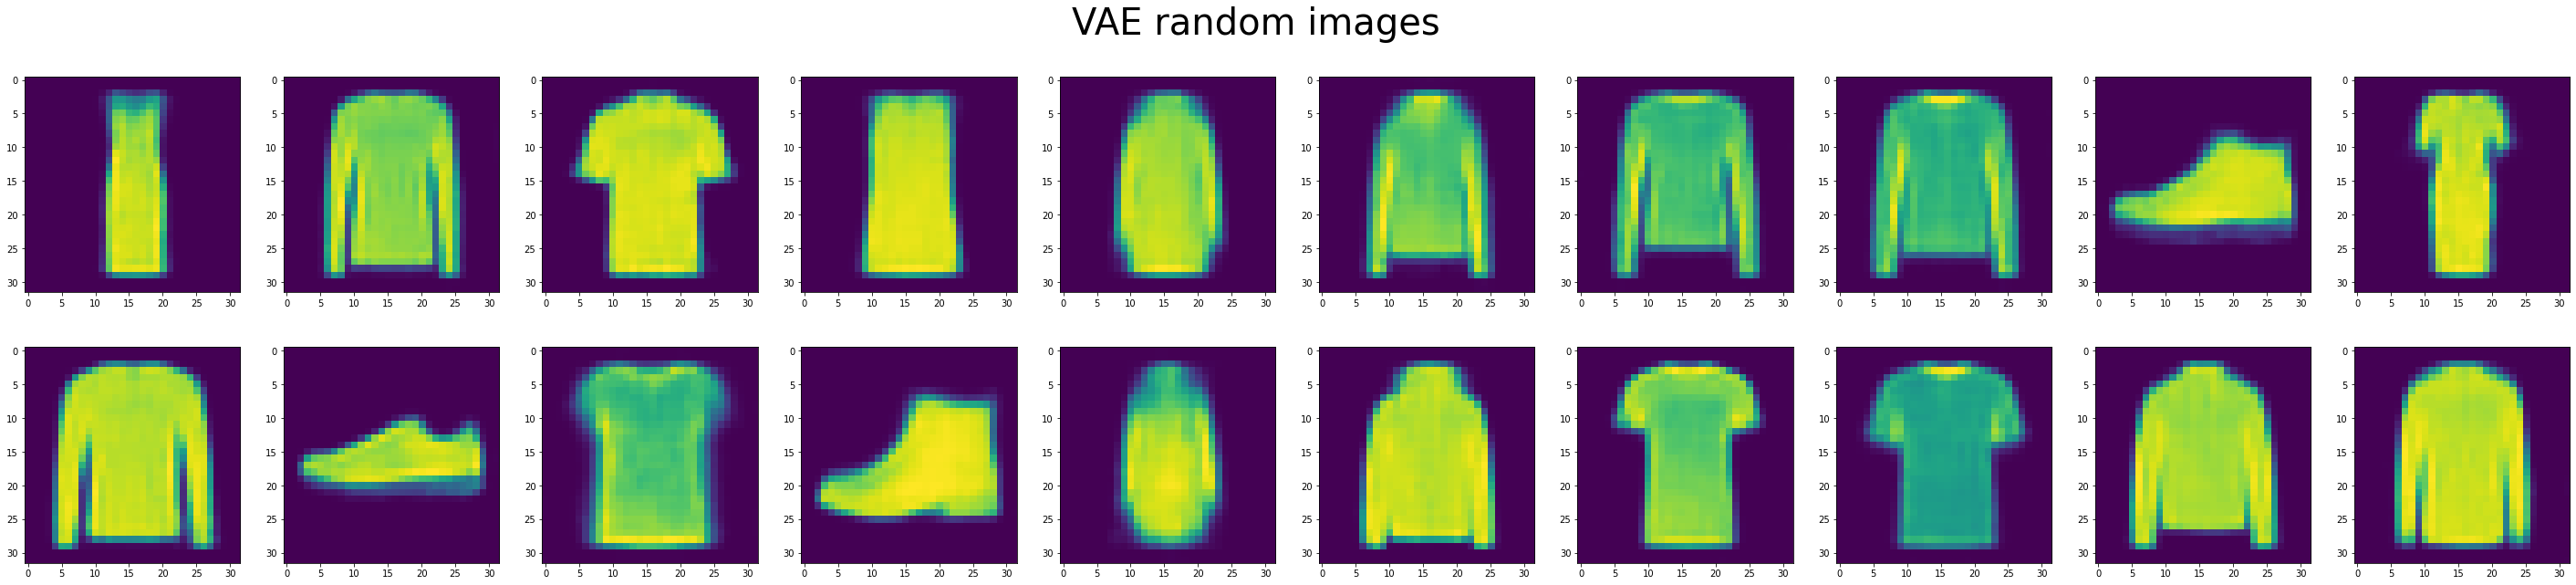

In [6]:
#### INSERT CODE HERE ####

figure_1, axes = plt.subplots(nrows=2, ncols=10, figsize=(50, 10))
indices = np.random.randint(0, x_train.shape[0]-1, size=10)

# plot to show images after reconstruction
for i, row in enumerate(axes):
    for j, subplot in enumerate(row):
        idx = indices[j]
        if i == 0:
            subplot.imshow(x_train[idx][:, :, 0])

        elif i == 1:
            subplot.imshow(vae.predict(x_train[idx].reshape(1, width, height, depth))[0, :, :, 0])

        if j == 0:
            subplot.set_ylabel({0:'Original images', 1:'Images after reconstruction'}[i], fontsize=15)

figure_1.suptitle("VAE images after reconstruction", fontsize = 40) 
plt.show()

    
# plot to show random images
figure_2, axes = plt.subplots(nrows=2, ncols=10, figsize=(50, 10))
for i, row in enumerate(axes):
    for j, subplot in enumerate(row):
        
        sample = K.random_normal(shape=(latent_dimension,), mean=0, stddev=1)
        subplot.imshow(decoder.predict(K.reshape(sample, (1,latent_dimension)))[0, :, :, 0])

figure_2.suptitle('VAE random images', fontsize = 40) 
plt.show()


## Task 4: Anomaly detection
**(a)** Use the VAE to obtain density/likelihood estimations for the normal and anomalous test sets, i.e. compute the ELBO (the negative of the loss function) for all points in both test sets. Make sure to keep the scores for the normal and anomaly sets separate from each other.

*Note: Unfortunately, Keras's `.evaluate()` does not allow to access the loss values of individual samples, it only returns the average loss over the entire input. A simple (but slow) workaround is to just use for loops over the entire input and use `.evaluate()` for each data point individually (set `verbose=0` to avoid a long output).*

In [7]:
#### INSERT CODE HERE ####

ELBO_score_list = []

for i in x_test:
    ELBO_score_list.append(-1 * vae.evaluate(i.reshape(1, width, height, depth), verbose=0))

# creating an array of boolean values where y_test != 1
y_true_values = y_test != 1
ELBO_values = np.array(ELBO_score_list)

ELBO_normal_data_value = ELBO_values[y_true_values]
ELBO_anomalous_data_value = ELBO_values[~y_true_values]

np.save("./ELBO_normal_data", ELBO_normal_data_value)
np.save("./ELBO_anomaly_data", ELBO_anomalous_data_value)
print("Calculating ELBO done.")

Calculating ELBO done.


**(b)** Visualise the scores in a histogram (`plt.hist()`) as well as a density plot (`sns.kdplot` from the `seaborn` library). Use two different colours: **green** for normal data, **red** for anomalous data, and show both normal and anomalous scores in the same plot (use transparency to make visualisation clearer), i.e. one figure with both histograms, and one figure with both density plots.

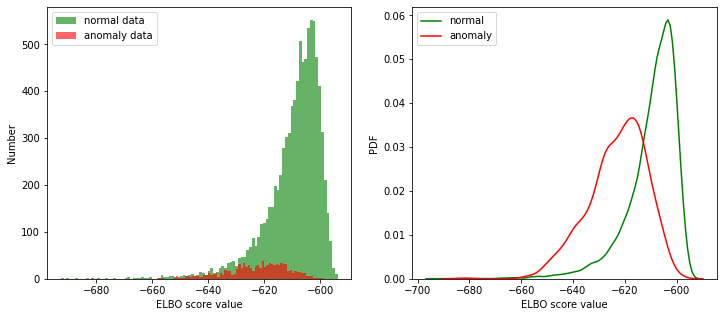

In [8]:
plt.subplots(1,2, figsize=(12,5))

plt.subplot(121)
_ = plt.hist(ELBO_normal_data_value,bins=100, density=False, color='g', alpha=.6, label="normal data")
_ = plt.hist(ELBO_anomalous_data_value, bins=100, density=False, color='r', alpha=.6, label="anomaly data")
plt.xlabel("ELBO score value")
plt.ylabel("Number")
plt.legend()

plt.subplot(122)
_ = sns.kdeplot(ELBO_normal_data_value, color='g', label="normal")
_ = sns.kdeplot(ELBO_anomalous_data_value, color='r', label="anomaly")
plt.xlabel("ELBO score value")
plt.ylabel("PDF")
plt.legend()

**(c)** Given these likelihood scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/).
* Plot an ROC curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.
* Plot a Precision-Recall curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.

*Implementation hints:*
* *See https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ for more information about ROC and PR curves and their implementation with `sklearn`.*
* *ROC/PR curves are typically used for binary classification. You can define anomaly as label 0 and normal as 1, and rescale the ELBO scores from part (a) to be between 0 and 1 (by using the minimum and maximum values in your ELBO results) to express them as binary classification probabilities.*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


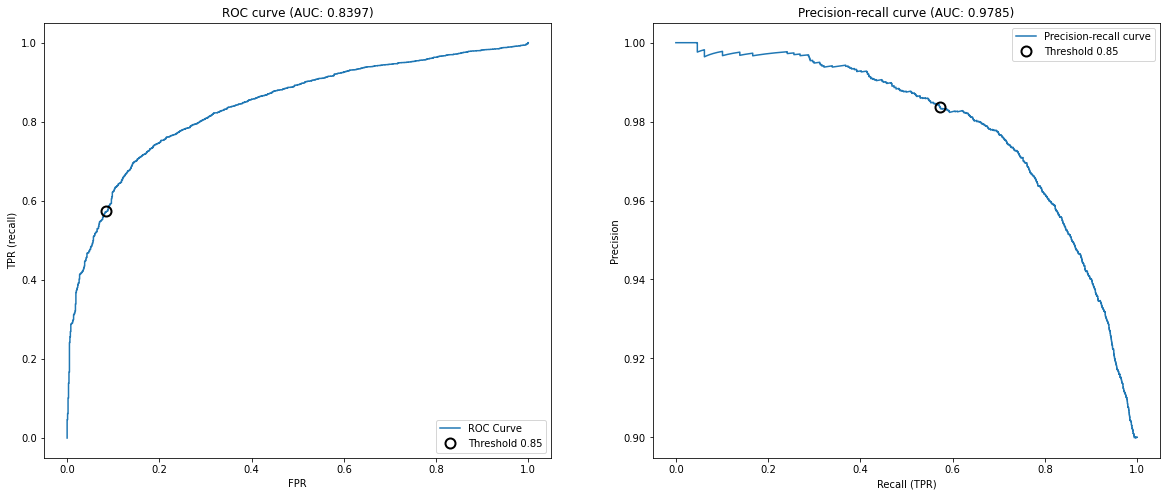

In [9]:

# function to perform minmax scaling
def minmax_scale(x):
    result = (x - x.min()) / (x.max() - x.min())
    return result

y_score_values = minmax_scale(ELBO_values)

threshold_value = 0.85
plt.subplots(1, 2, figsize=(20,8))

plt.subplot(121)

# ROC curve
plt.subplot(121)

# false positive rate, true positive rate, thresholds
fpr, tpr, thresholds = roc_curve(y_true_values, y_score_values)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

close_default = np.argmin(np.abs(thresholds - threshold_value))
plt.plot(fpr[close_default], tpr[close_default], 'o', markersize=10,
         label="Threshold {}".format(threshold_value), fillstyle="none", c='k', mew=2)
roc_auc = auc(fpr, tpr)
plt.title("ROC curve (AUC: {:.4f})".format(roc_auc))
plt.legend(loc=4)

# Precision-recall curve
plt.subplot(122)
prec, recall, thr = precision_recall_curve(y_true_values, y_score_values)
plt.plot(recall, prec, label='Precision-recall curve')
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision")

close_default = np.argmin(np.abs(thr - threshold_value))
plt.plot(recall[close_default], prec[close_default], 'o', markersize=10,
         label="Threshold {}".format(threshold_value), fillstyle="none", c='k', mew=2)

pr_auc = auc(recall, prec)
plt.title("Precision-recall curve (AUC: {:.4f})".format(pr_auc))
plt.legend()
plt.show()

**(d)** Ideally, a successful VAE for anomaly detection should represent (and thus reconstruct) normal data very well, but not anomalous data. Reconstruct some random images (at least 10 each) from the normal test set, as well as from the anomaly test set. Show the original images and their reconstructions on top of each other.

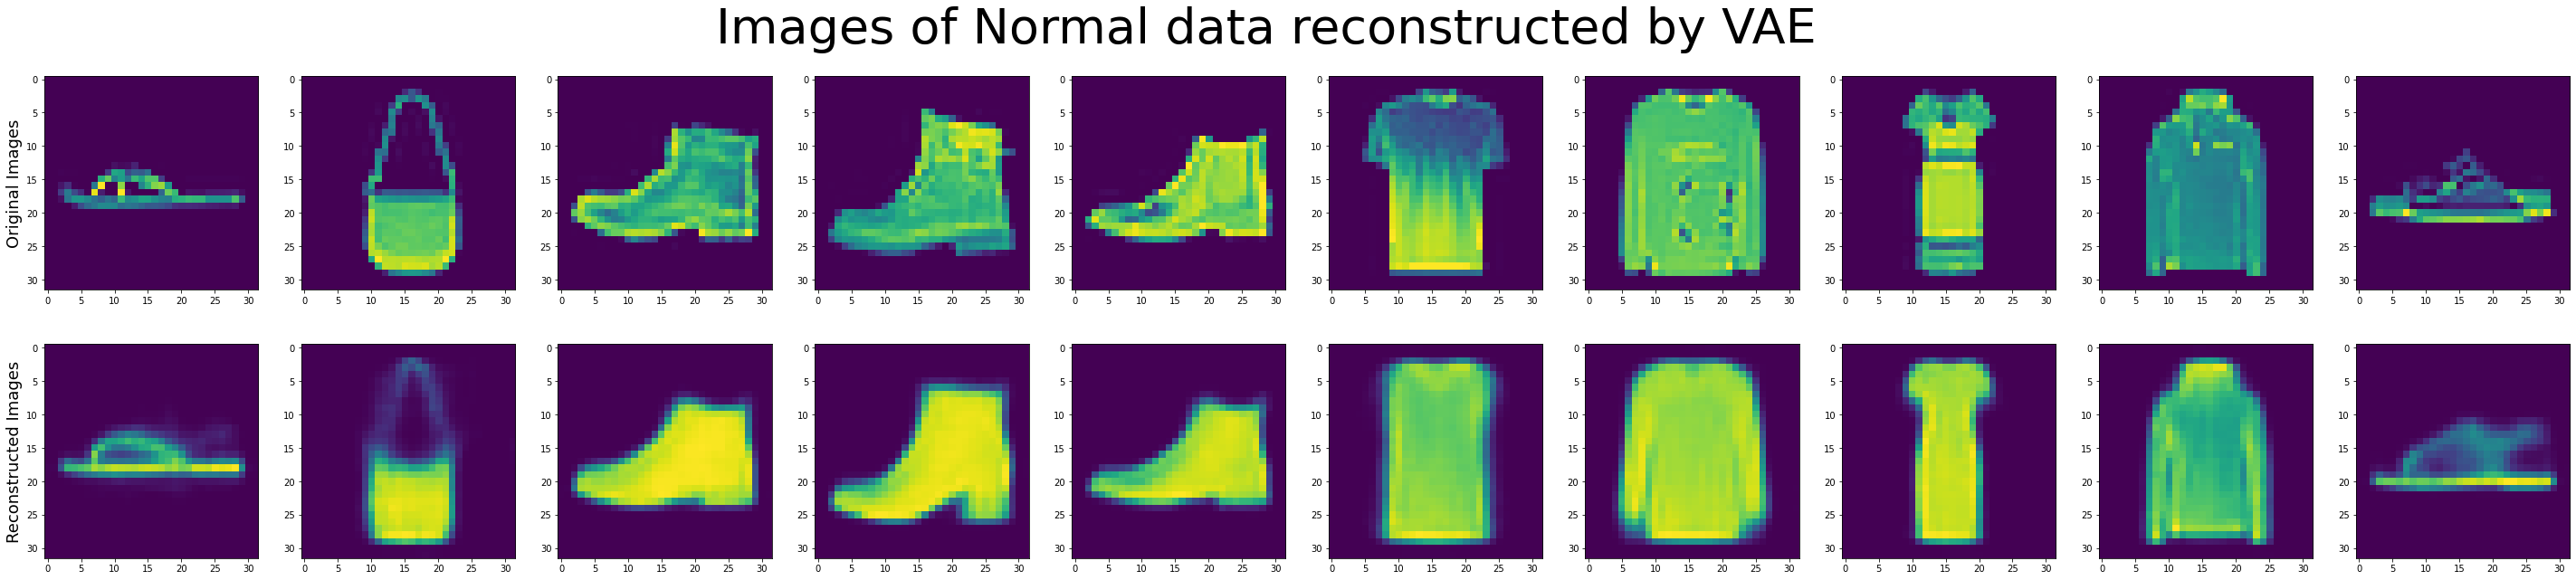

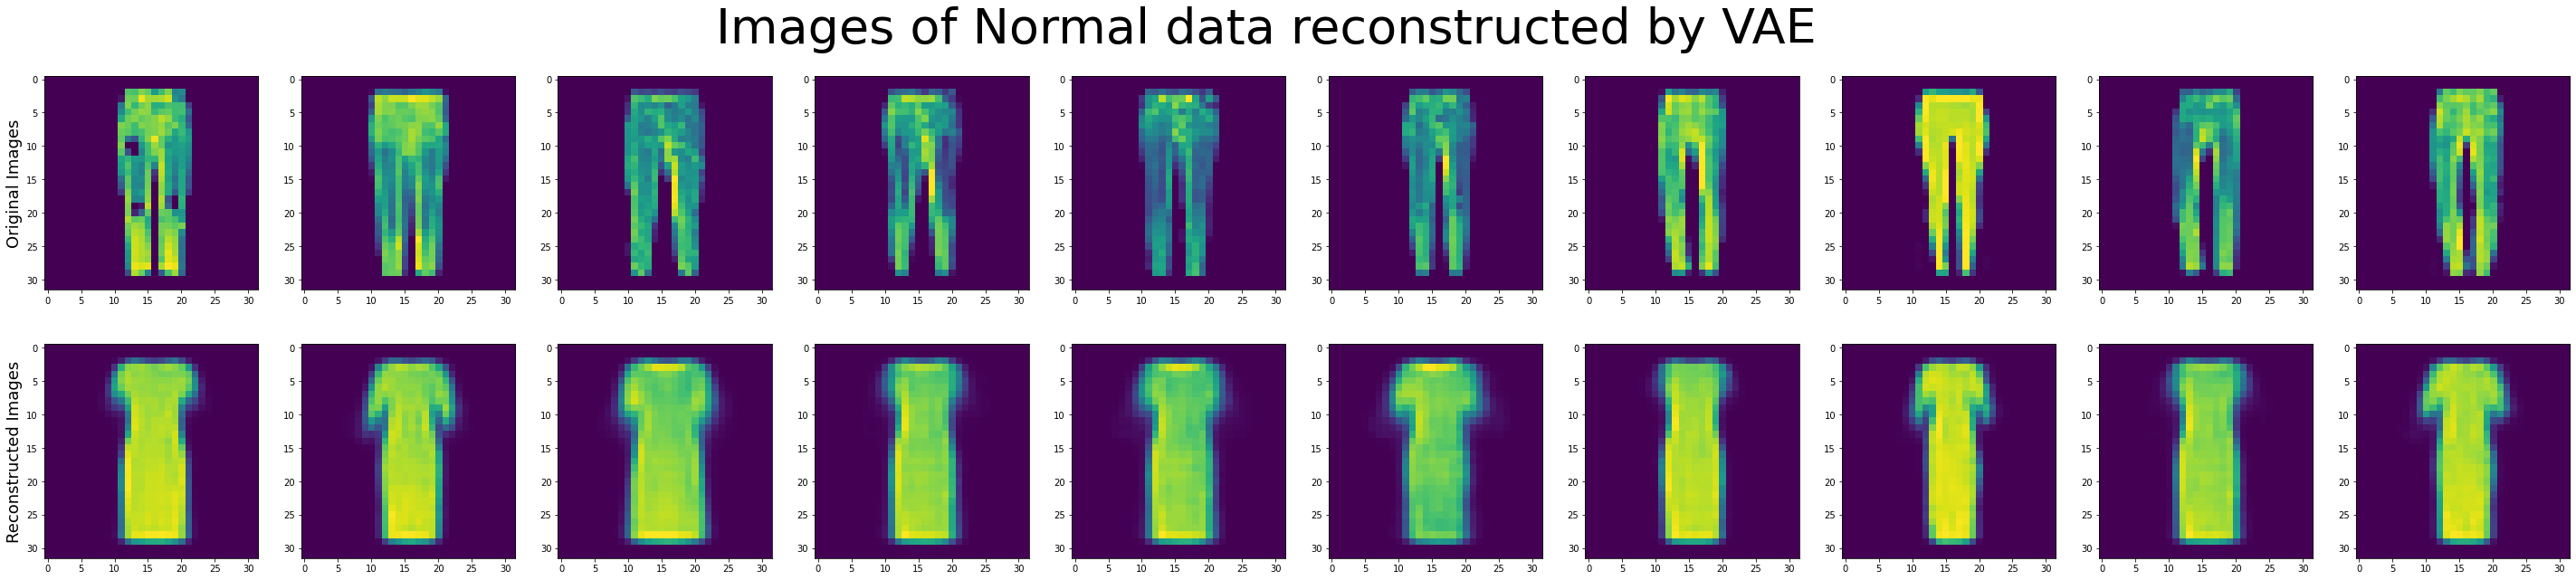

In [10]:

num_rows = 2
num_cols = 10
font_size = 18
title1 = "Images of Normal data reconstructed by VAE"
title2 = "Images of Anomalous data reconstructed by VAE"

# plot to show the images reconstructed by the VAE for normal data
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(50, 10))
indices = np.random.randint(0, x_test_normal_data.shape[0] - 1, size=num_cols)

for i, row in enumerate(axes):
    for j, subplot in enumerate(row):
        idx = indices[j]
        if i == 0:
            subplot.imshow(x_test_normal_data[idx][:, :, 0])
        elif i == 1:
            subplot.imshow(vae.predict(x_test_normal_data[idx].reshape(1, width, height, depth))[0, :, :, 0])

        if j == 0: 
            subplot.set_ylabel({0:'Original Images', 1:'Reconstructed Images'}[i], fontsize=font_size)

fig.suptitle(title1, fontsize = font_size * 3) 
plt.show()

# plot to show the images reconstructed by the VAE for anomalous data
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(50, 10))
indices = np.random.randint(0, x_test_anomalous_data.shape[0] - 1, size=num_cols)

for i, row in enumerate(axes):
    for j, subplot in enumerate(row):
        idx = indices[j]
        if i == 0:
            subplot.imshow(x_test_anomalous_data[idx][:, :, 0])
        elif i == 1:
            subplot.imshow(vae.predict(x_test_anomalous_data[idx].reshape(1, width, height, depth))[0, :, :, 0])

        if j == 0: 
            subplot.set_ylabel({0:'Original Images', 1:'Reconstructed Images'}[i], fontsize=font_size)

fig.suptitle(title1, fontsize = font_size * 3) 
plt.show()

**(e)** Give a detailed discussion of your results; does the anomaly detection perform well? Why do you think so? What could be improved? Discuss each of the results from parts (b), (c), and (d) separately. 


##### (b)The graph of EBLO score values shows that the data is not balanced. The green and red colors show the graph for the normal data and anomaly data respectively. Yes, the anomaly detection performs better as compared to normal one. The green histogram shows that number of normal data points is larger as compared to anomaly data points which is red in color. The ELBO score value of normal data points is higher (approx. -610) as compared to ELBO score value of anomaly data points (approx. -620). The range of ELBO score values for Normal data and Anomalous data overlap with each other. This indicates that classification of anomalous data does have errors. #####

##### (c) According to the ROC curve, we can see that the model can easily distinguish the different classes. The model can distinguish the anomaly data and normal data with good accuracy. The ROC curve (AUC 0.8397) is empirical proof that model performance is good and accurate. The area under the precision recall curve is high, which shows that the model has low false positive rate as well as low false negative rate (corresponding top high precision and high recall respectively.) Threshold is 0.85, which shows the trade-off between the precision and recall.#####

##### (d) From the out images, we can see that the performance for “Images of Normal data reconstructed by VAE” is better than “Images of Anomalous data reconstructed by VAE”. The sample generation from anomalous data has not so good performance which results into the low EBLO score value. As expected, the implemented VAE represents Normal images better than Anomalous images. #####
